**Exploring data from Pedro**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

filename = 'ExportCypherviaAPOC29Aug.xlsx'
data = pd.read_excel(filename,sheetname=None)
pd.set_option('max_rows', 5)

Here I define a function to compute the number of pairs over the years, normalised by the number of documents found in that year. This function receives as input a pair of text a - b, and b - a. Sounds silly, but it makes the following computation easier.

In [2]:
ppy = data['Pairs per year']
ndocs = data['Number Docs per Year']
TPVal = ppy['Term Pair'].values
nall = len(ppy['Year'])
#print 'Number of entries: %d'%nel
def get_pair_evol(t3,t3_inv):
    # Gets the normalised number of pairs for all years
    idp1 = np.where((TPVal == t3) | (TPVal == t3_inv))[0] #get all pairs
    years = np.sort(np.unique(ppy['Year'][idp1])) # all relevant years for the pair
    nyears = len(years) 
    sum_pairs = ppy.iloc[idp1].groupby('Year') # Grouping by year
    sum_alldocs = sum_pairs.sum()
    ids = [np.where(ndocs['YEAR'].values == x)[0] for x in years] 
    ids_list = [x[0] for x in ids]
    cc = ndocs['Count docs'].values[ids_list]
    norm_pairs = [sum_alldocs.values[x]/(0.0 + cc[x]) for x in range(nyears)]
    np_list = [x[0] for x in norm_pairs]
    
    return years, np_list,t3 #returns the years and list of normalised pairs


Here I calculate all possible combinations of pairs, including those in reverse order


In [3]:
import itertools

terms = np.unique(ppy['t1.Term'])
nterms = len(terms)
ncomb = int(nterms*(nterms-1)/2.)
print 'All pair combinations:', ncomb
comb = list(itertools.combinations(terms,2))

t3_list = ['%s - %s'%(x[0], x[1]) for x in list(comb)]
t3_list_inv = ['%s - %s'%(x[1], x[0]) for x in list(comb)]


All pair combinations: 21945


Here the code goes through the database finding each pair combination and running the function from above. To speed up the computation, it is done in parallel using `Pool` in `multiprocessing`. Then, it also computes an average and plots the results

In [13]:
import multiprocessing as mp

year_arr = np.sort(np.unique(ppy['Year'].values)) # It'll contain all years found in all data
nallyears = len(year_arr)

nel = ncomb
print nel

nproc = 4  # number of parallel processes
i0 = 0  
i1 = nel
npp = int((i1-i0+1.0)/(nproc+0.0)) # number of terms that each processor will deal with      

def do_pairs(ip):
    out = []
    x0 = npp*ip
    x1 = ncomb-1 if ip == nproc-1 else npp*(ip+1) #the last processor absorbs possible rounding error
    np_arr = [[] for x in range(nallyears)]
    idarr  = [[] for x in range(nallyears)]
    for x in range(x0,x1):
        t3 = t3_list[x]
        t3_inv = t3_list_inv[x]
        year, nplist,pname = get_pair_evol(t3,t3_inv) 
        for iy in range(nallyears):
            year_i = year_arr[iy]
            if year_i in year:
                idnp = year.tolist().index(year_i) # index of year to find correct pair element
                np_arr[iy].append(nplist[idnp])
                idarr[iy].append(x)
      
    print 'Process %d done.'%ip
    return [np_arr, idarr] 

pool = mp.Pool(processes=nproc)
res = [pool.apply_async(do_pairs, args=(x,)) for x in range(nproc)]
np_arr_p = [p.get()[0] for p in res]
id_arr_p  = [p.get()[1] for p in res]

med_pairs = np.zeros(nallyears)
for iy in range(nallyears):
    med_pairs[iy] = np.median(sum([x[iy] for x in np_arr_p],[]))
        
nzero = np.where((med_pairs >0) & (~np.isnan(med_pairs)))[0]

21945
Process 0 done.
Process 1 done.
Process 3 done.
Process 2 done.


[0.22222222 0.08695652 0.05555556 0.03846154 0.03703704 0.09090909
 0.03571429 0.03571429 0.03030303 0.02816901 0.03571429 0.03076923
 0.03389831 0.02325581 0.01010101 0.00881057 0.00843882 0.00806452
 0.00651466 0.00634921 0.00609756 0.00441501 0.00473934 0.00514139
 0.00524934 0.0043573  0.00400802 0.00362976 0.00277778 0.00407332
 0.00244798 0.00168776 0.00134318 0.00166482 0.00131637 0.001168
 0.0010395  0.00097119 0.00089127 0.00086195 0.00085494 0.00146735]


Finally, things are plotted

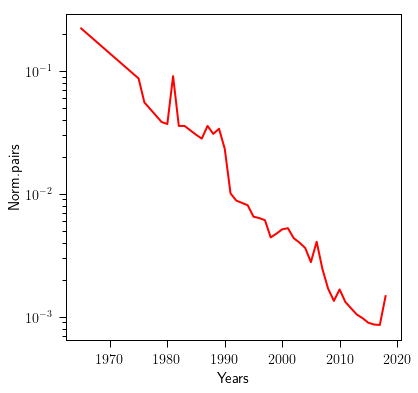

In [15]:
plt.figure(1,figsize=(6,6))
#for ip in nproc:
#    idp = id_arr_p[ip]
#    ids = np.unique(idp)
#    for ii in ids:
#        idy = np.where(idp == ii
    
#    np = len(ix)
#    for ii in range(np):
#        plt.plot(ix[ii],ix[ii],'k-',linewidth=0.2) 

plt.plot(np.asarray(year_arr)[nzero], np.asarray(med_pairs)[nzero],'r-',linewidth=2)
plt.xlabel('Years',fontsize=15)
plt.ylabel('Norm.pairs',fontsize=15)
plt.yscale('log')

[0.2222222222222222, 0.2222222222222222, 0.2222222222222222]